In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import random
from imblearn.over_sampling import SMOTE
import rcca
from EDA_helper import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE

## Import Datasets

In [20]:
def process_rf(stratified=False):
    """ 
    1. Read in energ, ratio

    2. format_df(ratio, ratings)

    2b. format_df(energ, ratings)

    merged = left_join(ratio, energ)

    3. join_numerical(merged, ratings)

    4. data_split to get holdout set (apply drop_na on this)

    will have quarterly granularity for test

    5. interpolate train data to fill in missing (expand quarterly to monthly) 
    """
    ratings = pd.read_excel("../datasets/ratings_all_energ_new.xlsx")
    ratio = pd.read_excel("../datasets/ratios_2_all_energ_new.xlsx")
    energ = pd.read_excel("../datasets/energ_specific_all_new.xlsx")
    # ratings = pd.read_excel("../datasets/ratings_2_06-17.xlsx")
    # ratio = pd.read_excel("../datasets/ratio_figs_2.xlsx")
    cols = ratio.columns
    ratio = ratio.drop(cols[0], axis=1)
    ratio = ratio.rename(columns = {'Public Date':'Data Date','EXCHANGE TICKER SYMBOL - HISTORICAL':'Ticker Symbol'})

    ratio1, ratings1 = format_df(ratio.copy(), ratings.copy(), 
                                 ['Trailing P/E to Growth (PEG) ratio','Dividend Yield', 
                                  'Interest/Average Total Debt', 'Free Cash Flow/Operating Cash Flow'])

    numer = list(ratio1.columns[4:-1])
    # yr = ['2006', '2007', '2008','2009','2010','2011','2012','2013']
    # X1,Y1,full1 = join_numerical(ratio1, ratings1, numerical=numer)
    cols = energ.columns
#     print(cols)
    # aa = cols[[0,1,2,3,4,5,6, 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
    aa = cols[[0,1,2,3,4,5,6, 10,11,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
    energ1 = energ.drop(
           aa, 
        axis=1)
    # energ1 = energ_.fillna(energ_.mean()) 
    # energ1, _ = format_df(energ.copy(), ratings.copy(), 
    #                             aa)
    energ1['Data Date'] = energ1['Data Date'].astype(str)
    energ1.shape
    features = pd.merge(ratio1, energ1,how='left',on=["Data Date", "Ticker Symbol"])
#     len(features["Ticker Symbol"].unique())
    lst3 = [value for value in ratio["Ticker Symbol"].unique() if value in energ["Ticker Symbol"].unique()]
    # ratio1["Ticker Symbol"].unique()
#     len(lst3)
#     print(len(ratio["Ticker Symbol"].unique()), len(energ["Ticker Symbol"].unique()), 
#           len(ratio1["Ticker Symbol"].unique()), len(energ1["Ticker Symbol"].unique()))

    first_col = features.pop("Ticker Symbol") 
    ff = len(features.columns)
    features.insert(ff, "Ticker Symbol", first_col)
    numer = list(features.columns[4:-1])

    X1,Y1,full1 = join_numerical(features, ratings1, numerical=numer)
    
    if stratified:
        full1 = full1.reset_index()
        comps = list(full1['Ticker Symbol'].unique())
        labout = []
        inout = []
        v_labout = []
        v_inout = []
        t_labout = []
        t_inout = []
        for c in comps:
            curr_in = full1.index[full1['Ticker Symbol'] == c]
            indXd = X1[curr_in,:]
            indYd = Y1[curr_in]
            if np.random.binomial(1, 0.9):
                if np.random.binomial(1, 0.8):
                    inout.append(indXd)
                    labout.append(indYd)
                else:
                    v_inout.append(indXd)
                    v_labout.append(indYd)
            else:
                t_inout.append(indXd)
                t_labout.append(indYd)
        X1,Y1, X_val_, Y_val, X_hold_,Y_hold = (np.vstack(inout),np.vstack(labout), np.vstack(v_inout),
                                               np.vstack(v_labout), np.vstack(t_inout), np.vstack(t_labout)) 
        ss = StandardScaler()
        scl_X = ss.fit_transform(X1)
        scl_X = np.nan_to_num(scl_X)
        enc_Y_, _ = encode(Y1, 'full') 

        X_val = ss.transform(X_val_)
        X_val = np.nan_to_num(X_val)
        Y_val, _ = encode(Y_val, 'full')
        
        X_hold = ss.transform(X_hold_)
        X_hold = np.nan_to_num(X_hold)

        Y_hold, _ = encode(Y_hold, 'full')
        minny = np.abs(np.min((np.min(enc_Y_), np.min(Y_val), np.min(Y_hold))))
        enc_Y = enc_Y_ + minny
        Y_val += minny
        Y_hold += minny


    else:
        X_val, Y_val = np.array([]),np.array([])
        X1, X_hold_,Y1, Y_hold = train_test_split(X1, Y1, test_size=0.2, random_state=100)
        ss = StandardScaler()
        scl_X = ss.fit_transform(X1)
        scl_X = np.nan_to_num(scl_X)
        enc_Y_, _ = encode(Y1, 'full') 

        X_hold = ss.transform(X_hold_)
        X_hold = np.nan_to_num(X_hold)

        Y_hold, _ = encode(Y_hold, 'full')
        minny = np.abs(np.min((np.min(enc_Y_), np.min(Y_hold))))
        enc_Y = enc_Y_ + minny
        Y_hold += minny
    print(scl_X.shape, X_val.shape, X_hold.shape)
    return scl_X, enc_Y, X_val, Y_val, X_hold, Y_hold

In [21]:
## NOTE: we do not want to separate a Val set as GDA function will do that
X_train, Y_train, X_val,Y_val, X_test, Y_test = process_rf()

Unique Companies in Ratings:  335
Unique Companies in Features:  253
changed
Intersection of Companies:  97
(6375, 26) (0,) (1594, 26)


## For convenience, I wrote a function that allows us to perform hyperparameter tuning and regularization over our 4 model classes: LDA, QDA, LDA with SMOTE, QDA with SMOTE

In [22]:
def GDA(X, Y, full=None, shrink=None, reg=0.0, smote=True):
    
    results = {}
    if smote:
        X_train, Y_train, _, _, X_test, Y_test = data_split(X, Y, full, split=[0.8, 0.0],smote=True, neigh=4)
        # LDA w/ smote
        lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrink)
        lda.fit(X_train, Y_train)
        preds_train = lda.predict(X_train)
        preds_test = lda.predict(X_test)
        results['lda_smote'] = (np.mean(Y_train == preds_train), np.mean(Y_test == preds_test))
        # QDA w/ smote
        qda = QuadraticDiscriminantAnalysis(reg_param = reg)
        qda.fit(X_train, Y_train)
        preds_train = qda.predict(X_train)
        preds_test = qda.predict(X_test)

        results['qda_smote'] = (np.mean(Y_train == preds_train), np.mean(Y_test == preds_test))
    
    X_train, Y_train, _, _, X_test, Y_test = data_split(X, Y, full, split=[0.8, 0.0], smote=False)
    # LDA w/o smote
    lda = LinearDiscriminantAnalysis(solver='eigen',shrinkage=shrink)
    lda.fit(X_train, Y_train)
    preds_train = lda.predict(X_train)
    preds_test = lda.predict(X_test)
    results['lda'] = (np.mean(Y_train == preds_train), np.mean(Y_test == preds_test))
    # QDA w/o smote
    qda = QuadraticDiscriminantAnalysis(reg_param = reg)
    qda.fit(X_train, Y_train)
    preds_train = qda.predict(X_train)
    preds_test = qda.predict(X_test)
    results['qda'] = (np.mean(Y_train == preds_train), np.mean(Y_test == preds_test))    
    
    df_ = pd.DataFrame(results.values(),index=results.keys(), columns = ['train accuracy, reg: ' + str(reg), 'test accuracy, reg: ' + str(reg)])
    max_test=np.argmax(df_.iloc[:, 1:].values)
    max_elem = pd.DataFrame(df_.iloc[max_test, :])
    return df_, max_elem
    
    

## Testing LDA/QDA assumptions

Before we can proceed with applying these models, we must first see if they satisfy the necessary assumptions.

### LDA assumptions
 - Class conditional distributions are Gaussian: $p(\textbf{X} \mid Y = k) \sim \mathcal{N}(\mu_k, \Sigma_k)$
 - All class conditional dist. have equal covariance: $\forall k$ classes &nbsp; &nbsp; $\Sigma_k = \Sigma$
 

 ### QDA assumptions
 - Class conditional distributions are Gaussian: $p(\textbf{X} \mid Y = k) \sim \mathcal{N}(\mu_k, \Sigma_k)$
 - Conditional dist. can have unequal covariance: $\Sigma_k$


In [23]:
from pingouin import multivariate_normality
# Henze-Zirkler Multivariate Normality Test

classes = np.unique(Y_train)
for k in classes:
    sub_x = X_train[Y_train == k,:]
    print(multivariate_normality(sub_x, alpha=.05))


HZResults(hz=80, pval=0.0, normal=False)
HZResults(hz=108, pval=0.0, normal=False)
HZResults(hz=4.560702577813036, pval=0.0, normal=False)
HZResults(hz=16.355319199558846, pval=0.0, normal=False)
HZResults(hz=8.17824057260861, pval=0.0, normal=False)
HZResults(hz=5.352710485729784, pval=0.0, normal=False)
HZResults(hz=5.718241597681815, pval=0.0, normal=False)
HZResults(hz=5.184256784855533, pval=0.0, normal=False)
HZResults(hz=4.108393757576158, pval=0.0, normal=False)
HZResults(hz=11.415270564692657, pval=0.0, normal=False)
HZResults(hz=6.219344406953118, pval=0.0, normal=False)
HZResults(hz=3.216211650341139, pval=0.0, normal=False)
HZResults(hz=4.121419631253522, pval=0.0, normal=False)
HZResults(hz=76, pval=0.0, normal=False)
HZResults(hz=32, pval=0.0, normal=False)
HZResults(hz=412, pval=0.0, normal=False)
HZResults(hz=32, pval=0.0, normal=False)
HZResults(hz=400, pval=0.0, normal=False)


### Since the p-values for our statistic test are below 0.5, we reject the null hypothesis and conclude that $p(\textbf{X} \mid Y = k)$ are not Gaussian.

### Performing a quick sanity check, we plot the class conditional distributions for some class k over a few features. Clearly we see the data is NOT Gaussian. 

<AxesSubplot:>

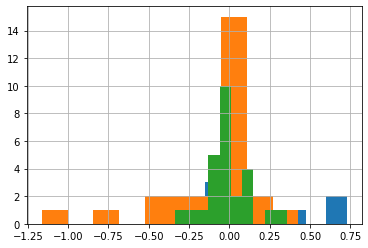

In [24]:
sanity_x = X_train[Y_train == classes[len(classes)//2],:]
pd.Series(sanity_x[0]).hist()
pd.Series(sanity_x[3]).hist()
pd.Series(sanity_x[6]).hist()

### Testing for equal Covariance

Inspecting only at the variances of the class conditional covariance matrices, we see that they don't match up at all over different classes.

In [25]:
classes = np.unique(Y_train)
vars_ = np.zeros((classes.shape[0], X_train.shape[1]))
for i,k in enumerate(classes):
    sub_x = X_train[Y_train == k,:]
    df_temp = pd.DataFrame(sub_x).cov()
    vars_[i] = df_temp.to_numpy().diagonal() 
    
vars_

array([[5.95704749e-02, 1.56167284e-03, 2.36260222e-02, 1.02447729e-02,
        4.12242690e-02, 5.63990539e-03, 2.78329718e-01, 9.68363344e-01,
        2.71858140e-01, 2.42842277e+00, 1.78129330e-01, 5.05709368e-01,
        1.50915772e-02, 4.75508528e-01, 1.76288468e-02, 1.25694937e-01,
        2.34695861e-01, 2.80472477e-02, 1.66301036e-01, 2.01842991e-01,
        2.81512124e-01, 1.41572630e-02, 1.31241659e-02, 6.57737050e-03,
        2.28066656e-02, 3.39824330e-02],
       [1.95954772e-01, 1.94786596e-04, 6.36289148e+00, 8.55611813e-03,
        3.16979862e-02, 9.00480918e-03, 6.14856388e+01, 1.95899780e-01,
        1.35738726e+00, 2.46953595e+00, 5.12555816e-01, 4.27489674e-01,
        3.02977487e-03, 5.01742121e-01, 7.34316085e-01, 3.24445855e-01,
        2.78598323e-01, 5.00492106e+00, 1.81453177e-01, 2.30951517e-01,
        4.11492244e-01, 1.87126053e-02, 2.66451383e-02, 1.48674444e-02,
        0.00000000e+00, 2.55797008e-02],
       [5.12970429e-01, 5.05336166e-01, 2.08163242e+00

### We conclude that the assumptions for Gaussian Discriminant Analysis fail and thus we shouldn't expect great results from this method. However, we may still be able to get good results despite this

In [26]:
from sklearn.metrics import plot_confusion_matrix,mean_absolute_error, classification_report
warnings.filterwarnings('ignore')
dfs = []
best_reg = 0
best_test = 0
best_model = ''
# for j in range(1,len(xs)):
for i in [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]:
    df, maxi = GDA(X_train, Y_train, shrink='auto', reg=i)
    if maxi.iloc[1, 0] > best_test:
        best_reg = i
        best_test = maxi.iloc[1, 0]
        best_model = maxi.columns[0]
#         best_data = j
    dfs.append(df)
    
#     print(maxi)
print("Best Test Accuracy: ",best_test)
print("Best Regularization: ",best_reg)
print("Best Model: ", best_model)
# print(mean_absolute_error())
# print('Best Data: ', best_data)
pd.concat(dfs, axis=1)


Best Test Accuracy:  0.4235294117647059
Best Regularization:  1e-05
Best Model:  qda_smote


,"train accuracy, reg: 0.0","test accuracy, reg: 0.0","train accuracy, reg: 1e-05","test accuracy, reg: 1e-05","train accuracy, reg: 0.0001","test accuracy, reg: 0.0001","train accuracy, reg: 0.001","test accuracy, reg: 0.001","train accuracy, reg: 0.01","test accuracy, reg: 0.01","train accuracy, reg: 0.1","test accuracy, reg: 0.1","train accuracy, reg: 1.0","test accuracy, reg: 1.0","train accuracy, reg: 10.0","test accuracy, reg: 10.0"
lda_smote,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941,0.331687,0.312941
qda_smote,0.535524,0.419608,0.536664,0.423529,0.526026,0.420392,0.503609,0.401569,0.460866,0.371765,0.381459,0.305098,0.272986,0.253333,0.016717,0.004706
lda,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314,0.324902,0.304314
qda,0.435686,0.418039,0.435490,0.414902,0.418627,0.398431,0.387647,0.369412,0.358431,0.352941,0.300980,0.303529,0.259804,0.241569,0.002745,0.004706


### Unfortunately, Gaussian Discriminant Analysis doesn't perform anywhere near the desired level compared to other baselines.